# Entrainement des modèles de régression 

**Objectif**

Entrainer un modèle de regréssion à predire les prix d'un type de bien choisi (appartements ou maison) pour une zone géographique donnée (Paris, Marseille, etc.).

**Données**

`DVF+` est une base de données construite à partir des bases de données `DVF` (Demandes de Valeurs Foncières) & `BNB` (Base Nationale des Bâtiments). Cette base a été construite en utilisant les méthodes du module `preprocessing` de la librairie `lib`. 

**Méthode** 

1. Choix d'une zone géographique (`geo_area`) et d'une type de bien (`property_type`)

<br>

2. Préparation du jeu de donneés pour la modélisation 
    - Filtrage des données (nombre de pièces, surface habitable, surface terrain, prix/m²)
    - Application du logarithme à la variable `l_valeur_fonciere`
    - Ajout des variables de tendance des prix du marché: moyenne mobile avec lag de 1 jour appliquée à la variable `valeur_fonciere`
    - Création des dummies 
    - Suppression des variables ayant une proportion de donnnées manquantes trop élevée

<br>

3. Séparation des jeux de données d'entrainement & test
    - Ordonner les transactions par ordre chronologique
    - Les 80% premières transactions sont dans le jeu de données train
    - Les 20% suivantes sont dans le jeu de données test 

<br>

4. Sélection des variables 
    - Calcul de l'information mutuelle (MI) entre les variables explicatives et la cible (`valeur_fonciere` ou `l_valeur_fonciere`)
    - `RandomForestRegressor` pour récupérer l'importance des variables mesurée par la *Mean Decrease Gini* (MDG)
    - Sélection des variables dont l'importance (MI et/ou MDG) est supérieure à seuil prédéfini (ex: quantile d'ordre 75%) 

<br>

5. Entrainement de plusieurs régresseurs
    - A partir des features sélectionnées
    - `LinearRegression`, `DecisionTreeRegressor`, `XGBRegressor`, ... 
    - Diagnostic

<br>

6. Optimisation du type de modèle le + adapté à la prédiction
    - Via [`optuna`](https://optuna.org/)
    - Identification de la combinaison d'hyperparamètres optimales
    - Ré-entrainement du modèle sur le train set 
    - Sauvegarde du modèle et du nom des features

## Setup

In [132]:
import sys
sys.path.append("../")

In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
from lib.dataset import (
    load_dvfplus, 
    prepare_dataset, 
    prepare_dummies, 
    temporal_train_test_split, 
    get_feature_vector, 
    get_target_vector, 
    compute_mutual_info, 
    compute_rf_importances, 
    select_important_features,
)

from lib.preprocessing.utils import get_na_proportion

from lib.dataset.utils import (
    get_categorical_vars, 
    get_most_frequent_levels,
    transform_price, 
    is_quantitative, 
)

from lib.model import (
    CustomRegressor, 
    compute_metrics, 
    display_regression_report, 
    plot_predictions, 
    get_predictions, 
)

from lib.model.optimize import optuna_objective

from lib.model.loader import save_model, load_model

In [175]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import rich 
from tqdm import tqdm

from multiprocessing import cpu_count

import pickle as pkl

In [ ]:
# estimators
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression, Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.neural_network import MLPRegressor

# optimization 
import optuna

In [ ]:
pd.set_option("display.max_columns", None)

In [142]:
DATA_DIR = "../data/"
BACKUP_DIR = "../backup/"

CPU_COUNT = cpu_count()

## Data

### Import

In [ ]:
df_args = {"geo_area": "Paris", "property_type": "flats"}

df = load_dvfplus(zip_dir=DATA_DIR, zip_name="dvf+", **df_args)

C:\Users\pemma\AppData\Local\Temp/ipykernel_6888/175102799.py:3: DtypeWarning: Columns (8,18,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_dvfplus(zip_dir=DATA_DIR, zip_name="dvf+", **df_args)


In [135]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,dependance,code_region,nom_departement,nom_region,degre_densite,pop,annee,trimestre,mois,jour,parcelle_id,code_iris,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),mur_pos_isol_ext,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,nom_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,l_etat_en_projet,l_etat_en_construction,l_etat_en_service,alea_argiles,alea_radon
0,2017-731653,2017-07-04,1,Vente,571110.0,16.0,NaN,RUE SAINT GILLES,8627,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AM0035,NaN,NaN,12.0,NaN,36.0,49.51,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,42.0,3.0,NaN,NaN,NaN,NaN,NaN,2.366404,48.858043,0,11,Paris,Île-de-France,Paris,34788.0,2017,3,7,4,75103000AM0035,751031102.0,<1948,AVANT_1949,16.0,35.0,269.0,13.0,69.0,8.0,485.0,16.0,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,323.0,"Ancien hôtel Aubert de Fontenay ou Salé, actue...",0.0,0.0,26.0,23.0,26.0,0.0,0.0,1.0,NaN,Faible
1,2017-731655,2017-07-04,1,Vente,1578150.0,66.0,NaN,RUE DE LISBONNE,5708,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000CO0044,NaN,NaN,61.0,139.02,62.0,NaN,66.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,135.0,4.0,NaN,NaN,NaN,NaN,NaN,2.306998,48.877579,0,11,Paris,Île-de-France,Paris,36453.0,2017,3,7,4,75108000CO0044,751083203.0,<1948,AVANT_1949,20.0,47.0,197.0,40.3,181.9,38.0,212.0,42.6,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,388.0,Hôtel de Camondo,0.0,2.0,26.0,23.0,23.0,0.0,0.0,1.0,NaN,Faible
2,2017-731657,2017-07-05,1,Vente,2810880.0,27.0,NaN,RUE MARBEUF,5993,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000AR0060,NaN,NaN,93.0,219.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,220.0,6.0,NaN,NaN,NaN,NaN,NaN,2.304234,48.869357,1,11,Paris,Île-de-France,Paris,36453.0,2017,3,7,5,75108000AR0060,751082903.0,<1948,AVANT_1949,24.0,37.0,1604.3,51.6,183.0,5.0,2721.0,88.0,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,271.0,Restaurant La Fermette Marbeuf,0.0,0.0,164.0,59.0,104.0,0.0,0.0,1.0,NaN,Faible
3,2017-731658,2017-07-03,1,Vente,130000.0,9.0,NaN,RUE DES INNOCENTS,4718,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000AO0081,NaN,NaN,114.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,14.0,1.0,NaN,NaN,NaN,NaN,NaN,2.347393,48.860387,0,11,Paris,Île-de-France,Paris,16252.0,2017,3,7,3,75101000AO0081,751010201.0,<1948,AVANT_1949,19.0,36.0,231.8,7.3,53.5,1.7,395.0,12.0,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443.0,Immeuble,0.0,0.0,147.0,97.0,105.0,0.0,0.0,1.0,NaN,Faible
4,2017-731661,2017-07-05,1,Vente,485000.0,30.0,NaN,RUE BEAUBOURG,759,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AT0078,NaN,NaN,4.0,50.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,38.0,3.0,NaN,NaN,NaN,NaN,NaN,2.354479,48.861846,0,11,Paris,Île-de-France,Paris,34788.0,2017,3,7,5,75103000AT0078,751031202.0,<1948,AVANT_1949,18.0,36.0,291.4,37.7,200.0,14.0,447.0,53.2,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,101.0,I

In [ ]:
df.shape

(160757, 86)

### Exploration 

L'objectif est de représenter les variables `valeur_fonciere`, `nombre_pieces_principales`, `surface_reelle_bati` et `surface_terrain` pour déterminer ensuite des filtres à appliquer aux données. 

In [ ]:
tmp = df.copy()

tmp["valeur_fonciere_m2"] = tmp.apply(
    lambda row: transform_price(row.valeur_fonciere, log=False, area=row.surface_reelle_bati), 
    axis=1
)

In [ ]:
vars = ["valeur_fonciere_m2", "surface_reelle_bati", "surface_terrain"]
summary = tmp[vars].describe()
summary 

,valeur_fonciere_m2,surface_reelle_bati,surface_terrain
count,1.606810e+05,160756.000000,138.000000
mean,1.063960e+04,53.627877,420.840580
std,1.608160e+04,39.868650,576.248847
min,3.623188e-03,1.000000,33.000000
25%,8.548387e+03,28.000000,144.250000
50%,1.019048e+04,43.000000,210.500000
75%,1.193878e+04,68.000000,453.250000
max,2.155738e+06,1500.000000,4006.000000


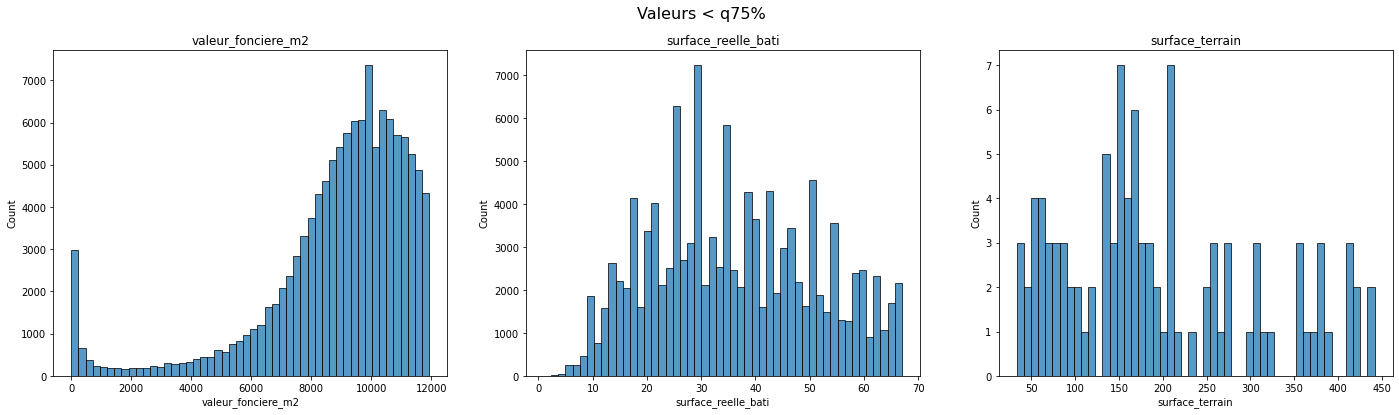

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
fig.suptitle("Valeurs < q75%", fontsize=16)

for var, ax in zip(vars, axes.flatten()): 
    thresold = summary[var]["75%"]

    x = tmp.loc[tmp[var] < thresold, var].dropna()
    sns.histplot(x, ax=ax, bins=50)
    ax.set_title(var);

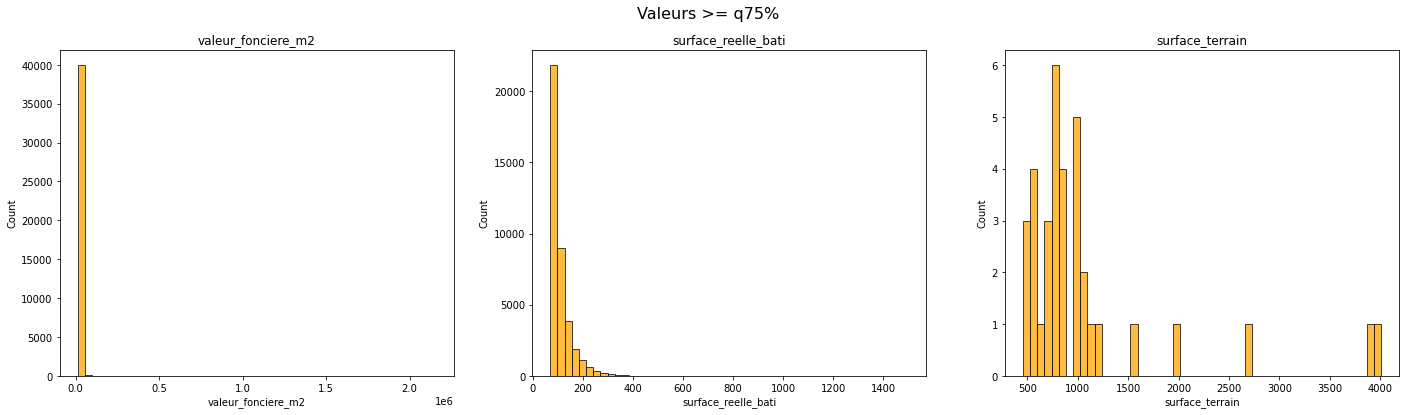

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(24, 6))
fig.suptitle("Valeurs >= q75%", fontsize=16)

for var, ax in zip(vars, axes.flatten()): 
    thresold = summary[var]["75%"]
    
    x = tmp.loc[tmp[var] > thresold, var].dropna()
    sns.histplot(x, ax=ax, bins=50, color="orange")
    ax.set_title(var); 

In [ ]:
for var in vars: 
    na_prop = get_na_proportion(tmp, var)
    print(f"{var}: {round(100 * na_prop, 3)}% valeurs manquantes")

valeur_fonciere_m2: 0.047% valeurs manquantes
surface_reelle_bati: 0.001% valeurs manquantes
surface_terrain: 99.914% valeurs manquantes


In [ ]:
tmp.nombre_pieces_principales.value_counts(dropna=False, normalize=True)

2.0     0.341186
1.0     0.261643
3.0     0.224625
4.0     0.102229
5.0     0.044334
6.0     0.015869
7.0     0.006028
8.0     0.001860
0.0     0.001219
9.0     0.000467
10.0    0.000292
11.0    0.000106
12.0    0.000037
13.0    0.000019
16.0    0.000012
20.0    0.000012
17.0    0.000012
22.0    0.000006
21.0    0.000006
19.0    0.000006
23.0    0.000006
26.0    0.000006
NaN     0.000006
14.0    0.000006
15.0    0.000006
Name: nombre_pieces_principales, dtype: float64

### Préparation du dataset

Application des filtres statiques sur les variables qui décrivent le bien : 
- nombre de pièces principales
- surface du bien
- valeur foncière/m²
- surface du terrain (pour les maisons)

D'après l'estimation faite par [meilleursagents](https://www.meilleursagents.com/prix-immobilier/paris-75000/), le prix/m² des appartements à Paris peut valoir entre de 6 847 € à 16 324 €. Afin d'être moins restrictif et pour prendre en compte les éventuelles fluctuations, on décide de sélectionner les biens tq $\text{valeur\_fonciere\_m2} \in [5 000, 20 000]$.

In [ ]:
preproc_args = {

    "quant_filters": {
        "nombre_pieces_principales": (1, 6), 
        "surface_reelle_bati": (9, 200), 
        "valeur_fonciere_m2": (5000, 20000)
    },  

    "mov_av_windows": [7, 14, 30, 90], 

    "neighborhood_var": "arrondissement"
    
}

df_prepoc, dvf_vars, bnb_vars = prepare_dataset(df, target_var="l_valeur_fonciere", **preproc_args)

Preprocessing summary:

{
    'created': [
        'l_valeur_fonciere',
        'l_surface_reelle_bati',
        'l_hauteur_mean',
        'l_altitude_sol_mean',
        'l_conso_ener_mean',
        'l_estim_ges_mean',
        'l_conso_ener_min',
        'l_estim_ges_min',
        'l_conso_ener_max',
        'l_estim_ges_max',
        'l_distance_batiment_historique_plus_proche',
        'valeur_fonciere_m2',
        'arrondissement',
        'l_valeur_fonciere_ma7',
        'l_valeur_fonciere_ma14',
        'l_valeur_fonciere_ma30',
        'l_valeur_fonciere_ma90'
    ],
    'removed': ['surface_terrain', 'alea_argiles', 'nom_commune']
}

In [ ]:
df_prepoc.head()

,id_mutation,date_mutation,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,dependance,trimestre,mois,parcelle_id,code_iris,periode_construction,periode_construction_max,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,enr_solaire_photovoltaique,enr_solaire_thermique_(chauffage)solaire_thermique_(ecs),enr_solaire_thermique_(ecs+chauffage),mur_pos_isol_ext,presence_climatisation,baie_orientation_indetermine,baie_orientation_nord,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,alea_radon,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_distance_batiment_historique_plus_proche,valeur_fonciere_m2,arrondissement,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90
0,2017-731653,2017-07-04,571110.0,42.0,3,0,3,7,75103000AM0035,751031102,<1948,AVANT_1949,16.0,35.0,269.0,13.0,69.0,8.0,485.0,16.0,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,323.0,0.0,0.0,26.0,23.0,26.0,Faible,13.255337,3.737670,2.772589,3.555348,5.594711,2.564949,4.234107,2.079442,6.184149,2.772589,5.777652,13597.857143,3,NaN,NaN,NaN,NaN
1,2017-731655,2017-07-04,1578150.0,135.0,4,0,3,7,75108000CO0044,751083203,<1948,AVANT_1949,20.0,47.0,197.0,40.3,181.9,38.0,212.0,42.6,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,Faible,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,5.203457,3.637586,5.356586,3.751854,5.961005,11690.000000,8,NaN,NaN,NaN,NaN
2,2017-731658,2017-07-03,130000.0,14.0,1,0,3,7,75101000AO0081,751010201,<1948,AVANT_1949,19.0,36.0,231.8,7.3,53.5,1.7,395.0,12.0,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,Faible,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,3.979682,0.530628,5.978886,2.484907,6.093570,9285.714286,1,NaN,NaN,NaN,NaN
3,2017-731661,2017-07-05,485000.0,38.0,3,0,3,7,75103000AT0078,751031202,<1948,AVANT_1949,18.0,36.0,291.4,37.7,200.0,14.0,447.0,53.2,0.0,0.0,0.0,ITI,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,6.0,60.0,40.0,45.0,Faible,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,5.298317,2.639057,6.102559,3.974058,4.615121,12763.157895,3,NaN,NaN,NaN,NaN
4,2017-731664,2017-07-11,820000.0,83.0,4,0,3,7,75108000AU0051,751083005,1970-1988,AVANT_1949,27.0,47.0,459.7,27.3,379.6,21.7,539.7,32.9,0.0,0.0,0.0,non isole,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,164.0,0.0,0.0,32.0,5.0,6.0,Faible,13.617060,4.418841,3.295837,3.850148,6.130574,3.306887,5.939118,3.077312,6.291013,3.493473,5.099866,9879.518072,8,13.750899,NaN,NaN,NaN


In [ ]:
df_prepoc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146188 entries, 0 to 146187
Data columns (total 56 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   id_mutation                                               146188 non-null  object 
 1   date_mutation                                             146188 non-null  object 
 2   valeur_fonciere                                           146188 non-null  float64
 3   surface_reelle_bati                                       146188 non-null  float64
 4   nombre_pieces_principales                                 146188 non-null  object 
 5   dependance                                                146188 non-null  int64  
 6   trimestre                                                 146188 non-null  object 
 7   mois                                                      146188 non-null  object 
 8   parc

### Encodage des dummies

In [ ]:
# categorical variable = pandas column with <= 30 unique values

categorical_vars = get_categorical_vars(df_prepoc, n_levels_max=30)   
categorical_vars.append("baie_orientation")

categorical_vars

['nombre_pieces_principales',
 'trimestre',
 'mois',
 'periode_construction',
 'periode_construction_max',
 'mur_pos_isol_ext',
 'alea_radon',
 'arrondissement',
 'baie_orientation']

In [ ]:
# select most representative levels for each categorical variable
dummy_ref_levels = get_most_frequent_levels(df_prepoc, categorical_vars)
dummy_ref_levels

{'baie_orientation': 'nord',
 'nombre_pieces_principales': '2',
 'trimestre': '3',
 'mois': '7',
 'periode_construction': '<1948',
 'periode_construction_max': 'AVANT_1949',
 'mur_pos_isol_ext': 'ITI',
 'alea_radon': 'Faible',
 'arrondissement': '18'}

In [ ]:
df_prepoc, dvf_vars, bnb_vars = prepare_dummies(
    df_prepoc, 
    categorical_vars, 
    dummy_ref_levels, 
    dvf_vars, 
    bnb_vars)

Preprocessing summary:

{
    'created': [
        'arrondissement_16',
        'arrondissement_3',
        'arrondissement_12',
        'mois_10',
        'mois_9',
        'mois_12',
        'nombre_pieces_principales_2',
        'arrondissement_7',
        'arrondissement_11',
        'nombre_pieces_principales_1',
        'nombre_pieces_principales_3',
        'nombre_pieces_principales_6',
        'arrondissement_15',
        'arrondissement_14',
        'arrondissement_1',
        'trimestre_3',
        'arrondissement_13',
        'mois_6',
        'mois_7',
        'mois_4',
        'trimestre_2',
        'arrondissement_4',
        'mois_11',
        'nombre_pieces_principales_4',
        'arrondissement_19',
        'arrondissement_8',
        'arrondissement_9',
        'mois_1',
        'mois_8',
        'arrondissement_5',
        'trimestre_4',
        'arrondissement_6',
        'mois_3',
        'arrondissement_18',
        'mois_5',
        'arrondissement_10',
        'arrondissement_17',
        'arrondissement_2',
        'trimestre_1',
        'nombre_pieces_principales_5',
        'mois_2',
        'arrondissement_20',
        'periode_construction_1989-1999',
        'periode_construction_max_DE_1961_A_1974',
        'mur_pos_isol_ext_non isole',
        'mur_pos_isol_ext_isole',
        'periode_construction_max_DE_1949_A_1960',
        'periode_construction_max_DE_1975_A_1993',
        'mur_pos_isol_ext_ITE+ITR',
        'periode_construction_2006-2012',
        'mur_pos_isol_ext_ITI+ITR',
        'mur_pos_isol_ext_ITR',
        'periode_construction_max_DE_1994_A_2000',
        'mur_pos_isol_ext_ITE',
        'mur_pos_isol_ext_ITI',
        'mur_pos_isol_ext_ITI+ITE',
        'periode_construction_max_non renseigné',
        'periode_construction_>2012',
        'periode_construction_bad inf',
        'periode_construction_1949-1970',
        'periode_construction_bad sup',
        'periode_construction_1970-1988',
        'periode_construction_2000-2005',
        'periode_construction_max_AVANT_1949',
        'periode_construction_<1948',
        'alea_radon_Faible',
        'periode_construction_max_APRES_2011',
        'periode_construction_max_DE_2001_A_2010'
    ],
    'removed': [
        'baie_orientation_nord',
        'nombre_pieces_principales_2',
        'trimestre_3',
        'mois_7',
        'periode_construction_<1948',
        'periode_construction_max_AVANT_1949',
        'mur_pos_isol_ext_ITI',
        'alea_radon_Faible',
        'arrondissement_18',
        'enr_solaire_thermique_(chauffage)solaire_thermique_(ecs)',
        'enr_solaire_thermique_(ecs+chauffage)'
    ]
}

In [ ]:
# set id_mutation as index 

df_prepoc.set_index("id_mutation", inplace=True)

In [ ]:
df_prepoc.head()

,date_mutation,valeur_fonciere,surface_reelle_bati,dependance,parcelle_id,code_iris,hauteur_mean,altitude_sol_mean,conso_ener_mean,estim_ges_mean,conso_ener_min,estim_ges_min,conso_ener_max,estim_ges_max,enr_solaire_photovoltaique,presence_climatisation,baie_orientation_indetermine,baie_orientation_ouest,baie_orientation_est,baie_orientation_horizontale,baie_orientation_est_ou_ouest,baie_orientation_sud,distance_batiment_historique_plus_proche,qpv,nb_lot_garpark,nb_lot_tot,nb_log,nb_lot_tertiaire,l_valeur_fonciere,l_surface_reelle_bati,l_hauteur_mean,l_altitude_sol_mean,l_conso_ener_mean,l_estim_ges_mean,l_conso_ener_min,l_estim_ges_min,l_conso_ener_max,l_estim_ges_max,l_distance_batiment_historique_plus_proche,valeur_fonciere_m2,l_valeur_fonciere_ma7,l_valeur_fonciere_ma14,l_valeur_fonciere_ma30,l_valeur_fonciere_ma90,nombre_pieces_principales_1,nombre_pieces_principales_3,nombre_pieces_principales_4,nombre_pieces_principales_5,nombre_pieces_principales_6,trimestre_1,trimestre_2,trimestre_4,mois_1,mois_10,mois_11,mois_12,mois_2,mois_3,mois_4,mois_5,mois_6,mois_8,mois_9,periode_construction_1949-1970,periode_construction_1970-1988,periode_construction_1989-1999,periode_construction_2000-2005,periode_construction_2006-2012,periode_construction_>2012,periode_construction_bad inf,periode_construction_bad sup,periode_construction_max_APRES_2011,periode_construction_max_DE_1949_A_1960,periode_construction_max_DE_1961_A_1974,periode_construction_max_DE_1975_A_1993,periode_construction_max_DE_1994_A_2000,periode_construction_max_DE_2001_A_2010,periode_construction_max_non renseigné,mur_pos_isol_ext_ITE,mur_pos_isol_ext_ITE+ITR,mur_pos_isol_ext_ITI+ITE,mur_pos_isol_ext_ITI+ITR,mur_pos_isol_ext_ITR,mur_pos_isol_ext_isole,mur_pos_isol_ext_non isole,arrondissement_1,arrondissement_10,arrondissement_11,arrondissement_12,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_19,arrondissement_2,arrondissement_20,arrondissement_3,arrondissement_4,arrondissement_5,arrondissement_6,arrondissement_7,arrondissement_8,arrondissement_9
id_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-731653,2017-07-04,571110.0,42.0,0,75103000AM0035,751031102,16.0,35.0,269.0,13.0,69.0,8.0,485.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,323.0,0.0,0.0,26.0,23.0,26.0,13.255337,3.737670,2.772589,3.555348,5.594711,2.564949,4.234107,2.079442,6.184149,2.772589,5.777652,13597.857143,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731655,2017-07-04,1578150.0,135.0,0,75108000CO0044,751083203,20.0,47.0,197.0,40.3,181.9,38.0,212.0,42.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,2.0,26.0,23.0,23.0,14.271764,4.905275,2.995732,3.850148,5.283204,3.696351,5.203457,3.637586,5.356586,3.751854,5.961005,11690.000000,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-731658,2017-07-03,130000.0,14.0,0,75101000AO0081,751010201,19.0,36.0,231.8,7.3,53.5,1.7,395.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,443.0,0.0,0.0,147.0,97.0,105.0,11.775290,2.639057,2.944439,3.583519,5.445875,1.987874,3.979682,0.530628,5.978886,2.484907,6.093570,9285.714286,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-731661,2017-07-05,485000.0,38.0,0,75103000AT0078,751031202,18.0,36.0,291.4,37.7,200.0,14.0,447.0,53.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,6.0,60.0,40.0,45.0,13.091904,3.637586,2.890372,3.583519,5.674697,3.629660,5.298317,2.639057,6.102559,3.974058,4.615121,12763.157895,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-731664,2017-07-11,820000.0,83.0,0,75108000AU0051,751083005,27.0,47.0,459.7,27.3,379.6,21.7,539.7,32.9,0.0,0.0,0

In [ ]:
to_remove = [
    "valeur_fonciere", 
    "valeur_fonciere_m2",
    "surface_reelle_bati", 
    "parcelle_id",
    "code_iris",
    "hauteur_mean",
    "altitude_sol_mean",
    "conso_ener_mean",
    "estim_ges_mean",
    "conso_ener_min",
    "estim_ges_min",
    "conso_ener_max",
    "estim_ges_max",
    "distance_batiment_historique_plus_proche"    
]

df_prepoc.drop(labels=to_remove, axis=1, inplace=True)

In [ ]:
df_prepoc.shape

(115743, 90)

### Train/test split 

In [ ]:
df_train, df_test, train_dates, test_dates = temporal_train_test_split(df_prepoc, date_var="date_mutation", train_prop=.8)

In [ ]:
print(f"Période d'entrainement : {train_dates.min()} / {train_dates.max()}") 

Période d'entrainement : 2017-07-01 / 2021-07-15


In [ ]:
target = "l_valeur_fonciere"

X_tr, features = get_feature_vector(df_train, return_features=True, target=target)
y_tr = get_target_vector(df_train, target=target)

X_te, y_te = get_feature_vector(df_test, target=target), get_target_vector(df_test, target=target)

In [ ]:
print(f"{X_tr.shape[0]:,} exemples d'entrainement pour {X_tr.shape[1]} features.")
print(f"{X_te.shape[0]:,} exemples test.")

76,199 exemples d'entrainement pour 88 features.
21,097 exemples test.


In [ ]:
rich.print(features)

[
    'dependance',
    'enr_solaire_photovoltaique',
    'presence_climatisation',
    'baie_orientation_indetermine',
    'baie_orientation_ouest',
    'baie_orientation_est',
    'baie_orientation_horizontale',
    'baie_orientation_est_ou_ouest',
    'baie_orientation_sud',
    'qpv',
    'nb_lot_garpark',
    'nb_lot_tot',
    'nb_log',
    'nb_lot_tertiaire',
    'l_surface_reelle_bati',
    'l_hauteur_mean',
    'l_altitude_sol_mean',
    'l_conso_ener_mean',
    'l_estim_ges_mean',
    'l_conso_ener_min',
    'l_estim_ges_min',
    'l_conso_ener_max',
    'l_estim_ges_max',
    'l_distance_batiment_historique_plus_proche',
    'l_valeur_fonciere_ma7',
    'l_valeur_fonciere_ma14',
    'l_valeur_fonciere_ma30',
    'l_valeur_fonciere_ma90',
    'nombre_pieces_principales_1',
    'nombre_pieces_principales_3',
    'nombre_pieces_principales_4',
    'nombre_pieces_principales_5',
    'nombre_pieces_principales_6',
    'trimestre_1',
    'trimestre_2',
    'trimestre_4',
    'mois_1',
    'mois_10',
    'mois_11',
    'mois_12',
    'mois_2',
    'mois_3',
    'mois_4',
    'mois_5',
    'mois_6',
    'mois_8',
    'mois_9',
    'periode_construction_1949-1970',
    'periode_construction_1970-1988',
    'periode_construction_1989-1999',
    'periode_construction_2000-2005',
    'periode_construction_2006-2012',
    'periode_construction_>2012',
    'periode_construction_bad inf',
    'periode_construction_bad sup',
    'periode_construction_max_APRES_2011',
    'periode_construction_max_DE_1949_A_1960',
    'periode_construction_max_DE_1961_A_1974',
    'periode_construction_max_DE_1975_A_1993',
    'periode_construction_max_DE_1994_A_2000',
    'periode_construction_max_DE_2001_A_2010',
    'periode_construction_max_non renseigné',
    'mur_pos_isol_ext_ITE',
    'mur_pos_isol_ext_ITE+ITR',
    'mur_pos_isol_ext_ITI+ITE',
    'mur_pos_isol_ext_ITI+ITR',
    'mur_pos_isol_ext_ITR',
    'mur_pos_isol_ext_isole',
    'mur_pos_isol_ext_non isole',
    'arrondissement_1',
    'arrondissement_10',
    'arrondissement_11',
    'arrondissement_12',
    'arrondissement_13',
    'arrondissement_14',
    'arrondissement_15',
    'arrondissement_16',
    'arrondissement_17',
    'arrondissement_19',
    'arrondissement_2',
    'arrondissement_20',
    'arrondissement_3',
    'arrondissement_4',
    'arrondissement_5',
    'arrondissement_6',
    'arrondissement_7',
    'arrondissement_8',
    'arrondissement_9'
]

## Feature selection 

On applique deux méthodes sur le jeu de données d'entrainement pour identifier les variables explicatives pouvant expliquer au mieux la valeur foncière des biens. 

La première méthode est l'information mutuelle. *Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. MI is based on the KL divergence.* On sélectionne ensuite les features ayant une MI supérieure à un certain seuil. 

La seconde méthode consiste à calculér la *Mean Decrease Gini* (MDG) à partir de l'estimateur `RandomForestRegressor` et de sélectionner les features ayant une MDG supérieure à certain seuil.  

In [ ]:
mi_values = compute_mutual_info(X_tr, y_tr, features)

In [ ]:
important_features_mi = select_important_features(mi_values, thresold="75%") 

In [ ]:
mdg_values = compute_rf_importances(X_tr, y_tr, features)

RandomForestRegressor fitted.
Train MAPE: 0.44%


In [ ]:
important_features_mdg = select_important_features(mdg_values, thresold="75%")

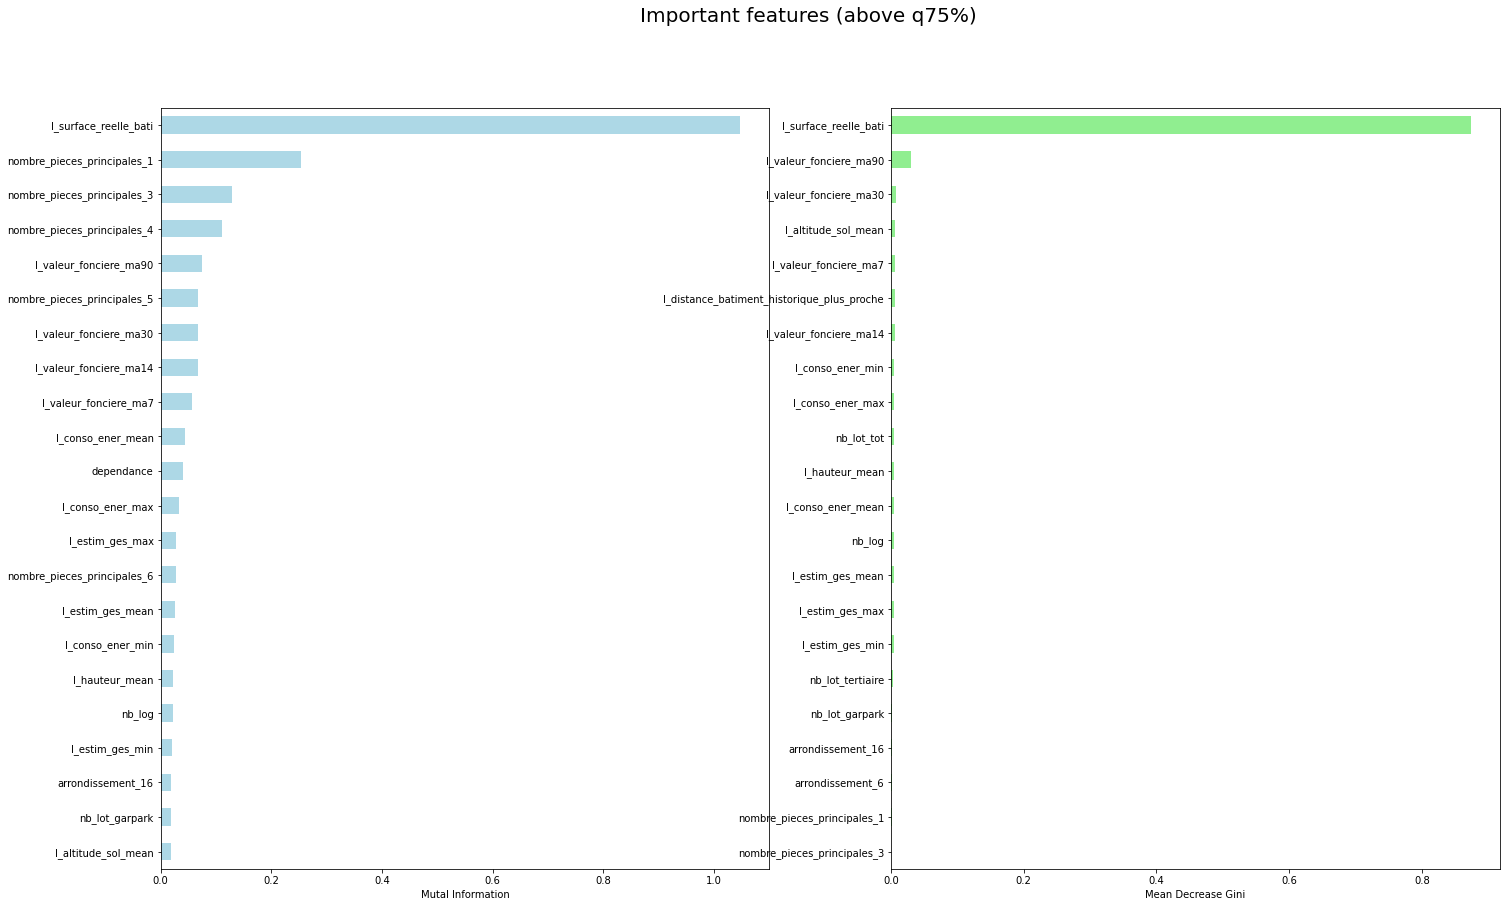

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 14))
fig.suptitle("Important features (above q75%)", fontsize=20)

mi_values[important_features_mi]\
    .sort_values()\
    .plot.barh(ax=axes[0], color="lightblue")

axes[0].set_xlabel("Mutal Information")

mdg_values[important_features_mdg]\
    .sort_values()\
    .plot.barh(ax=axes[1], color="lightgreen")

axes[1].set_xlabel("Mean Decrease Gini"); 

In [ ]:
# get the union of the two sets of important features
selected_features = list(set(important_features_mi + important_features_mdg))
rich.print(selected_features) 

[
    'arrondissement_16',
    'nb_lot_garpark',
    'nombre_pieces_principales_1',
    'l_conso_ener_min',
    'l_estim_ges_mean',
    'nombre_pieces_principales_3',
    'nombre_pieces_principales_6',
    'l_distance_batiment_historique_plus_proche',
    'nb_lot_tertiaire',
    'l_altitude_sol_mean',
    'l_estim_ges_max',
    'l_valeur_fonciere_ma14',
    'l_conso_ener_max',
    'l_surface_reelle_bati',
    'nb_lot_tot',
    'l_valeur_fonciere_ma30',
    'l_conso_ener_mean',
    'dependance',
    'nombre_pieces_principales_4',
    'l_hauteur_mean',
    'arrondissement_6',
    'l_valeur_fonciere_ma90',
    'nb_log',
    'l_estim_ges_min',
    'l_valeur_fonciere_ma7',
    'nombre_pieces_principales_5'
]

In [ ]:
X_tr = get_feature_vector(df_train, features=selected_features, return_df=False)
X_te = get_feature_vector(df_test, features=selected_features, return_df=False)

y_tr = get_target_vector(df_train, "l_valeur_fonciere", return_series=False) 
y_te = get_target_vector(df_test, "l_valeur_fonciere", return_series=False)

In [ ]:
X_tr.shape

(76199, 26)

## Modèles de régression 

### Sans optimisation

L'objectif est d'entrainer plusieurs régresseurs pour déterminer le type de modèle qui semble le plus adapté pour estimer la relation entre `l_valeur_fonciere` et les features sélectionnées. 

Régresseurs :
- `DummyRegressor`, 
- `LinearRegression`, 
- `Ridge`, 
- `DecisionTreeRegressor`, 
- `RandomForestRegressor`, 
- `XGBRegressor`, 
- `MLPRegressor`. 

On garde les paramètres par défaut de chaque estimateur. 

In [215]:
estimators = [
    DummyRegressor(), 
    LinearRegression(),
    Ridge(),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),
    XGBRegressor(), 
    MLPRegressor()
]

results = {
    "train": {}, 
    "test": {}
}

In [216]:
loop = tqdm(estimators) 

for estimator in loop:
    model_name = estimator.__class__.__name__
    loop.set_description(f"Fitting {model_name}...")

    model = CustomRegressor(estimator)
    model.fit(X_tr, y_tr)

    metrics_train = compute_metrics(model, X_tr, y_tr, to_prices=True)
    metrics_test = compute_metrics(model, X_te, y_te, to_prices=True)

    results["train"][model_name] = metrics_train
    results["test"][model_name] = metrics_test

Fitting MLPRegressor...: 100%|██████████| 7/7 [05:02<00:00, 43.21s/it]         


In [218]:
display_regression_report(results["train"], title="Metrics computed on valeur_fonciere (train set)")
display_regression_report(results["test"], title="Regression computed on valeur_fonciere (test set)")

                       Metrics computed on valeur_fonciere (train set)                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DummyRegressor              │ 268941.32     │ 60.22        │ 1.73e+11      │ -7.22        │
│ LinearRegression            │ 83004.47      │ 16.31        │ 1.84e+10      │ 88.57        │
│ Ridge                       │ 83005.82      │ 16.31        │ 1.84e+10      │ 88.57        │
│ DecisionTreeRegressor       │ 38.52         │ 0.01         │ 1.00e+07      │ 99.99        │
│ RandomForestRegressor       │ 30021.29      │ 5.75         │ 2.57e+09      │ 98.4         │
│ XGBRegressor                │ 68877.4       │ 13.72        │ 1.22e+10      │ 92.43        │
│ MLPRegressor                │ 100487.87     │ 19.37        │ 3.91e+10      │ 75.7         │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

                      Regression computed on valeur_fonciere (test set)                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DummyRegressor              │ 284892.97     │ 56.15        │ 2.01e+11      │ -10.98       │
│ LinearRegression            │ 84696.12      │ 15.57        │ 1.90e+10      │ 89.47        │
│ Ridge                       │ 84698.17      │ 15.57        │ 1.90e+10      │ 89.47        │
│ DecisionTreeRegressor       │ 121985.79     │ 22.58        │ 3.73e+10      │ 79.37        │
│ RandomForestRegressor       │ 83837.11      │ 15.27        │ 1.89e+10      │ 89.56        │
│ XGBRegressor                │ 81302.8       │ 15.08        │ 1.78e+10      │ 90.18        │
│ MLPRegressor                │ 103135.21     │ 18.75        │ 5.92e+10      │ 67.25        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

`XGBRegressor` semble être le modèle qui généralise le mieux puisque sa performance en test est la meilleure. On décide d'inspecter les performances de ce modèle. 

Le `DummyRegressor()` prédit par la moyenne et obtient de faibles performances en comparaison aux modèles de régression. 

In [ ]:
rich.print(results["XGBRegressor"]) 
xgb = results["XGBRegressor"]["model"]

{
    'model': CustomRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, max_bin=256,
                                       max_cat_threshold=64,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=6, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, ...)),
    'mae_tr': 0.13369736889883324,
    'mae_te': 0.1455025549126181,
    'mape_tr': 0.010389639836371794,
    'mape_te': 0.011247483347642395,
    'mse_tr': 0.03168577034740897,
    'mse_te': 0.037928785703244636,
    'r2_tr': 0.9277176443380509,
    'r2_te': 0.9125753410716149
}

In [ ]:
xgb_preds = get_predictions(xgb, X_te, y_te)

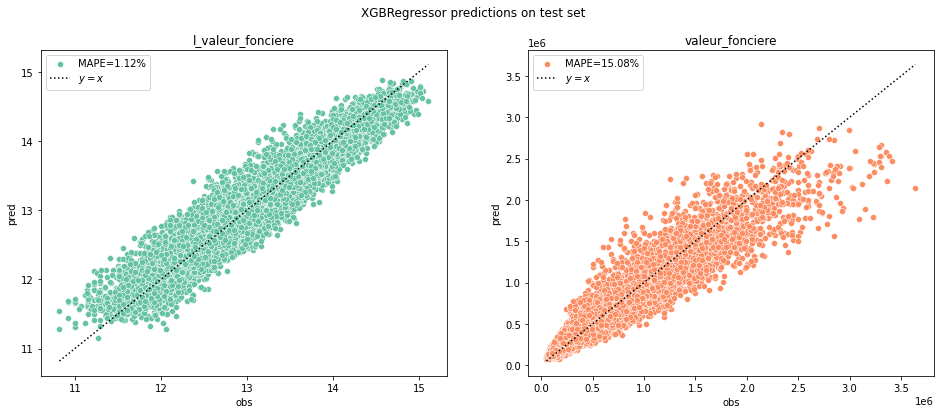

In [ ]:
colors = sns.color_palette(palette="Set2", n_colors=2)

fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle(f"XGBRegressor predictions on test set", fontsize=12)

for target, ax, color in zip(["l_valeur_fonciere", "valeur_fonciere"], axes.flatten(), colors):

    plot_predictions(
        y_true=xgb_preds[target]["y_true"],
        y_pred=xgb_preds[target]["y_pred"],
        color=color,
        title=target,
        ax=ax); 

### Optimisation `XGBRegressor`

`optuna` est un framework python permerttant de trouver les paramètres maximisant (ou minimisant) une fonction objectif. `optuna` utilise un historique des essais pour déterminer les valeurs d'hyperparamètres à essayer pour les prochains essais. À l'aide de ces données, il estime les zones les plus prometteuses pour atteindre l'objectif et essaie des valeurs dans cette zone. `optuna` estime ensuite une région encore plus prometteuse sur la base du nouveau résultat, et ainsi de suite jusqu'à convergence de la fonction cible. 

Pour afficher le dashboard résumant l'optimisation : 

```
optuna-dashboard sqlite:///./backup/__optuna/db.sqlite3

Listening on http://localhost:8080/
Hit Ctrl-C to quit.
```

#### Instantiation study `optuna`

In [146]:
optuna_args = {
    "storage": f"sqlite:///{BACKUP_DIR}__optuna/db.sqlite3", 
    "study_name": "optim-xgb-v0"
}

study = optuna.create_study(direction="minimize", **optuna_args)

In [143]:
regressor = CustomRegressor(estimator=XGBRegressor())

optim_args = {
    "regressor": regressor,
    "X_tr": X_tr,
    "y_tr": y_tr,
    "X_te": X_te,
    "y_te": y_te
}

rich.print(optim_args)

{
    'regressor': CustomRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, gpu_id=None,
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None, predictor=None,
                                       random_state=None, ...)),
    'X_tr': array([[  0.        ,   0.        ,   0.        , ...,   3.90399083,
         13.07303754,   0.        ],
       [  0.        , 557.        ,   0.        , ...,   0.        ,
         13.07303754,   0.        ],
       [  0.        ,  19.        ,   0.        , ...,   3.21887582,
         13.07303754,   0.        ],
       ...,
       [  0.        ,  89.91      ,   0.        , ...,   3.44680789,
         13.08884543,   0.        ],
       [  0.        ,   0.        ,   1.        , ...,   1.88706965,
         13.25307695,   0.        ],
       [  1.        ,  10.        ,   0.        , ...,   3.40119738,
         13.77834527,   0.        ]]),
    'y_tr': array([12.97733761, 12.99453001, 13.25163571, ..., 13.635187  ,
       12.36734079, 13.22238969]),
    'X_te': array([[ 1.        ,  0.        ,  0.        , ...,  1.62924054,
        13.77834527,  0.        ],
       [ 0.        ,  7.        ,  0.        , ...,  3.78418963,
        13.19124457,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  3.13549422,
        12.98086602,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.693867  ,
        13.20197739,  0.        ],
       [ 0.        ,  1.        ,  1.        , ...,  1.79175947,
        13.09099327,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  2.07944154,
        13.09099327,  0.        ]]),
    'y_te': array([14.16616743, 13.45883561, 12.63947712, ..., 13.9596109 ,
       12.25486281, 11.55837673])
}

In [147]:
optuna.load_study(**optuna_args)
study 

#### Recherche modèle optimal

In [148]:
study.optimize(
    func=lambda trial: objective_optuna(trial, **optim_args),
    n_trials=50,
    n_jobs=CPU_COUNT-2,
    show_progress_bar=True, 
)

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:46:45,404] Trial 14 finished with value: 0.15053539935584287 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.05496191231663146, 'reg_alpha': 0.00120490213579184, 'reg_lambda': 0.0021978854462066156}. Best is trial 7 with value: 0.15000588651740623.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:50:48,047] Trial 11 finished with value: 0.14865080768570638 and parameters: {'n_estimators': 799, 'max_depth': 5, 'learning_rate': 0.09768054431743059, 'reg_alpha': 0.0010149832586153762, 'reg_lambda': 0.0020487559336260387}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:50:48,964] Trial 15 finished with value: 0.14865080768570638 and parameters: {'n_estimators': 776, 'max_depth': 5, 'learning_rate': 0.07154352087114464, 'reg_alpha': 0.0015317310257408456, 'reg_lambda': 0.0029597375564287425}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:50:51,675] Trial 12 finished with value: 0.14865080768570638 and parameters: {'n_estimators': 767, 'max_depth': 5, 'learning_rate': 0.09096787915909545, 'reg_alpha': 0.0012184671488617075, 'reg_lambda': 0.0015228709349118276}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:51:00,958] Trial 16 finished with value: 0.14865080768570638 and parameters: {'n_estimators': 799, 'max_depth': 5, 'learning_rate': 0.09716843999679901, 'reg_alpha': 0.001074983576510703, 'reg_lambda': 0.0011533703998650954}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:51:16,678] Trial 13 finished with value: 0.14892201475234432 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.07963844156136066, 'reg_alpha': 0.0011323016736534894, 'reg_lambda': 0.0015365956426331951}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:55:08,335] Trial 18 finished with value: 0.1491264912632007 and parameters: {'n_estimators': 801, 'max_depth': 4, 'learning_rate': 0.09968392336756181, 'reg_alpha': 0.0070156485245249575, 'reg_lambda': 0.0011691337189727539}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:56:36,637] Trial 19 finished with value: 0.1489304407509606 and parameters: {'n_estimators': 766, 'max_depth': 5, 'learning_rate': 0.08536142965419852, 'reg_alpha': 0.004511529219540537, 'reg_lambda': 0.0013132696675408272}. Best is trial 11 with value: 0.14865080768570638.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:59:03,640] Trial 20 finished with value: 0.14853472415647326 and parameters: {'n_estimators': 817, 'max_depth': 6, 'learning_rate': 0.08265889963178218, 'reg_alpha': 0.7453499104169339, 'reg_lambda': 0.0019147273896051227}. Best is trial 20 with value: 0.14853472415647326.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:59:08,562] Trial 21 finished with value: 0.14872918143643957 and parameters: {'n_estimators': 835, 'max_depth': 6, 'learning_rate': 0.02777682596101976, 'reg_alpha': 0.6437347990851244, 'reg_lambda': 0.011745028901457392}. Best is trial 20 with value: 0.14853472415647326.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 11:59:35,896] Trial 22 finished with value: 0.14830505931973165 and parameters: {'n_estimators': 856, 'max_depth': 6, 'learning_rate': 0.03346091745756679, 'reg_alpha': 0.49694714254786193, 'reg_lambda': 0.016415709397468933}. Best is trial 22 with value: 0.14830505931973165.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:00:34,124] Trial 23 finished with value: 0.14870850197449992 and parameters: {'n_estimators': 635, 'max_depth': 6, 'learning_rate': 0.030877112987248236, 'reg_alpha': 0.32295948188314855, 'reg_lambda': 0.011226992043250589}. Best is trial 22 with value: 0.14830505931973165.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:00:58,383] Trial 26 finished with value: 0.16111060342089817 and parameters: {'n_estimators': 610, 'max_depth': 6, 'learning_rate': 0.03589500104341061, 'reg_alpha': 889.1966111994382, 'reg_lambda': 7.801415981548879}. Best is trial 22 with value: 0.14830505931973165.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:01:37,159] Trial 24 finished with value: 0.1486241140957815 and parameters: {'n_estimators': 618, 'max_depth': 6, 'learning_rate': 0.03635058943613771, 'reg_alpha': 0.39551443534690045, 'reg_lambda': 0.010631277233832913}. Best is trial 22 with value: 0.14830505931973165.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:03:12,200] Trial 17 finished with value: 0.1478438414131469 and parameters: {'n_estimators': 761, 'max_depth': 10, 'learning_rate': 0.08048589246801317, 'reg_alpha': 0.028844305721064972, 'reg_lambda': 956.3865169547506}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:03:49,115] Trial 25 finished with value: 0.14880197052437807 and parameters: {'n_estimators': 608, 'max_depth': 6, 'learning_rate': 0.036248755260661916, 'reg_alpha': 0.7317758728367176, 'reg_lambda': 0.021965148917919865}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:04:20,111] Trial 27 finished with value: 0.1487804405108581 and parameters: {'n_estimators': 622, 'max_depth': 6, 'learning_rate': 0.04102563122245071, 'reg_alpha': 2.954625699119759, 'reg_lambda': 0.011532901454463092}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:05:05,038] Trial 30 finished with value: 0.15074717491531314 and parameters: {'n_estimators': 415, 'max_depth': 8, 'learning_rate': 0.014932544330667125, 'reg_alpha': 3.0558660504087722, 'reg_lambda': 0.05809341180770151}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:08:36,935] Trial 28 finished with value: 0.1479570499057046 and parameters: {'n_estimators': 852, 'max_depth': 7, 'learning_rate': 0.04369479984381056, 'reg_alpha': 2.5552207166002474, 'reg_lambda': 0.047179549781395325}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:09:12,238] Trial 29 finished with value: 0.14828532202289235 and parameters: {'n_estimators': 880, 'max_depth': 7, 'learning_rate': 0.04619892934895648, 'reg_alpha': 4.068824489608032, 'reg_lambda': 0.04175413760323406}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:15:08,568] Trial 32 finished with value: 0.149191885908814 and parameters: {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.014454210228447196, 'reg_alpha': 2.869144312391428, 'reg_lambda': 9.174022443487397}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:16:53,964] Trial 36 finished with value: 0.16928273766098711 and parameters: {'n_estimators': 893, 'max_depth': 10, 'learning_rate': 0.005686249533764574, 'reg_alpha': 46.876412579480565, 'reg_lambda': 2.4493901825746467}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:19:43,627] Trial 31 finished with value: 0.14826809365124233 and parameters: {'n_estimators': 896, 'max_depth': 10, 'learning_rate': 0.01615767298205319, 'reg_alpha': 4.5213414799887985, 'reg_lambda': 2.6964386953793316}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:20:36,839] Trial 37 finished with value: 0.1512267747398252 and parameters: {'n_estimators': 886, 'max_depth': 8, 'learning_rate': 0.05730823075403404, 'reg_alpha': 37.12989376933403, 'reg_lambda': 0.2975702202992746}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:24:38,616] Trial 33 finished with value: 0.14834478063112688 and parameters: {'n_estimators': 895, 'max_depth': 10, 'learning_rate': 0.01575613886930486, 'reg_alpha': 0.13301654175226138, 'reg_lambda': 3.3219538334061345}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:27:56,059] Trial 34 finished with value: 0.14960731291143256 and parameters: {'n_estimators': 880, 'max_depth': 10, 'learning_rate': 0.058166137722684155, 'reg_alpha': 0.06492462355355008, 'reg_lambda': 4.086367361066144}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:31:53,567] Trial 35 finished with value: 0.1483892164419348 and parameters: {'n_estimators': 877, 'max_depth': 10, 'learning_rate': 0.016575518832478847, 'reg_alpha': 0.09064174340715751, 'reg_lambda': 2.6601360116737327}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:35:02,905] Trial 41 finished with value: 0.15085348795781303 and parameters: {'n_estimators': 706, 'max_depth': 9, 'learning_rate': 0.010550886288045066, 'reg_alpha': 8.087447291425885, 'reg_lambda': 55.97809267699929}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:35:48,648] Trial 38 finished with value: 0.14856402422943601 and parameters: {'n_estimators': 888, 'max_depth': 8, 'learning_rate': 0.057214074948732714, 'reg_alpha': 0.10700336279237106, 'reg_lambda': 0.3431389991989251}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:37:56,540] Trial 42 finished with value: 0.15102654164913393 and parameters: {'n_estimators': 702, 'max_depth': 9, 'learning_rate': 0.009720825484336545, 'reg_alpha': 6.974382686990673, 'reg_lambda': 40.81972361963517}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:38:33,992] Trial 40 finished with value: 0.1499893268962492 and parameters: {'n_estimators': 902, 'max_depth': 9, 'learning_rate': 0.010862202422430654, 'reg_alpha': 0.11820084133628654, 'reg_lambda': 77.18859669648799}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:44:52,299] Trial 39 finished with value: 0.14891104941023683 and parameters: {'n_estimators': 907, 'max_depth': 9, 'learning_rate': 0.053737007357074, 'reg_alpha': 0.10096041504001763, 'reg_lambda': 0.5012909229956746}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:44:58,300] Trial 43 finished with value: 0.1504299571745395 and parameters: {'n_estimators': 730, 'max_depth': 9, 'learning_rate': 0.011245566594290836, 'reg_alpha': 4.570665875375652, 'reg_lambda': 67.79424274411573}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:52:26,700] Trial 44 finished with value: 0.148962401408049 and parameters: {'n_estimators': 919, 'max_depth': 7, 'learning_rate': 0.02206076774859524, 'reg_alpha': 6.759387256092056, 'reg_lambda': 0.8001421935878578}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:56:07,173] Trial 45 finished with value: 0.14829412170428175 and parameters: {'n_estimators': 939, 'max_depth': 7, 'learning_rate': 0.02396439864110641, 'reg_alpha': 1.8163842464287123, 'reg_lambda': 0.7507698922509286}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:57:50,381] Trial 46 finished with value: 0.148377027555975 and parameters: {'n_estimators': 943, 'max_depth': 7, 'learning_rate': 0.02214010966132398, 'reg_alpha': 1.3732359125808498, 'reg_lambda': 0.7993578944458467}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 12:58:59,421] Trial 47 finished with value: 0.14847254634542315 and parameters: {'n_estimators': 957, 'max_depth': 7, 'learning_rate': 0.02390202559874324, 'reg_alpha': 1.8916461390879042, 'reg_lambda': 0.11438450439129841}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:05:59,817] Trial 49 finished with value: 0.14856491813599387 and parameters: {'n_estimators': 954, 'max_depth': 7, 'learning_rate': 0.02170259738357223, 'reg_alpha': 1.9679652880651881, 'reg_lambda': 0.11771723915021907}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:07:18,786] Trial 48 finished with value: 0.14859649655361323 and parameters: {'n_estimators': 958, 'max_depth': 7, 'learning_rate': 0.02116539083611904, 'reg_alpha': 0.015877052532839785, 'reg_lambda': 0.0815459746624219}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:10:22,194] Trial 52 finished with value: 0.1520679846607052 and parameters: {'n_estimators': 980, 'max_depth': 7, 'learning_rate': 0.006937820981833047, 'reg_alpha': 20.586140270590647, 'reg_lambda': 0.05714780078902152}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:12:20,172] Trial 53 finished with value: 0.15209967588777862 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.006860522037767542, 'reg_alpha': 23.124471696314266, 'reg_lambda': 0.004711153316929433}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:13:37,615] Trial 50 finished with value: 0.14827894006910022 and parameters: {'n_estimators': 985, 'max_depth': 7, 'learning_rate': 0.022345165480049847, 'reg_alpha': 1.4669694566539058, 'reg_lambda': 0.11533678159685237}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:14:52,627] Trial 57 finished with value: 0.15289462010072374 and parameters: {'n_estimators': 829, 'max_depth': 4, 'learning_rate': 0.04413000065219506, 'reg_alpha': 69.91828649652696, 'reg_lambda': 216.89697854887848}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:15:34,327] Trial 55 finished with value: 0.15077519174928458 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.04691738193651438, 'reg_alpha': 31.88857508156379, 'reg_lambda': 172.92383378966437}. Best is trial 17 with value: 0.1478438414131469.


c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1e3),
c:\Users\pemma\OneDrive - GENES\Ensae\Business Data Challenge\business-data-challenge\analysis\..\lib\model\optimize.py:28: FutureWarning: suggest_loguniform has been deprecated

[I 2023-03-31 13:15:54,276] Trial 51 finished with value: 0.14832359872785306 and parameters: {'n_estimators': 979, 'max_depth': 7, 'learning_rate': 0.022419972454837827, 'reg_alpha': 1.2625153370876259, 'reg_lambda': 0.1109179294042156}. Best is trial 17 with value: 0.1478438414131469.
[I 2023-03-31 13:21:23,370] Trial 54 finished with value: 0.14873560772783465 and parameters: {'n_estimators': 840, 'max_depth': 8, 'learning_rate': 0.04622187129041908, 'reg_alpha': 0.021943228296359998, 'reg_lambda': 0.04600282436572255}. Best is trial 17 with value: 0.1478438414131469.
[I 2023-03-31 13:22:33,768] Trial 60 finished with value: 0.1501884724706638 and parameters: {'n_estimators': 849, 'max_depth': 7, 'learning_rate': 0.028854268711444597, 'reg_alpha': 12.393847545189185, 'reg_lambda': 825.6838799471097}. Best is trial 17 with value: 0.1478438414131469.
[I 2023-03-31 13:23:00,838] Trial 56 finished with value: 0.14830988011282056 and parameters: {'n_estimators': 846, 'max_depth': 8, 'lea

In [152]:
rich.print(study.best_trial) 

FrozenTrial(number=17, values=[0.1478438414131469], datetime_start=datetime.datetime(2023, 3,
31, 11, 46, 45, 438019), datetime_complete=datetime.datetime(2023, 3, 31, 12, 3, 12, 94168), 
params={'learning_rate': 0.08048589246801317, 'max_depth': 10, 'n_estimators': 761, 
'reg_alpha': 0.028844305721064972, 'reg_lambda': 956.3865169547506}, 
distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 
'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'n_estimators': 
IntDistribution(high=1000, log=False, low=100, step=1), 'reg_alpha': 
FloatDistribution(high=1000.0, log=True, low=0.001, step=None), 'reg_lambda': 
FloatDistribution(high=1000.0, log=True, low=0.001, step=None)}, user_attrs={}, 
system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)

In [154]:
params_opt = study.best_params
rich.print(params_opt)

xgb_opt = CustomRegressor(estimator=XGBRegressor(**params_opt))

{
    'learning_rate': 0.08048589246801317,
    'max_depth': 10,
    'n_estimators': 761,
    'reg_alpha': 0.028844305721064972,
    'reg_lambda': 956.3865169547506
}

In [ ]:
xgb_opt.fit(X_tr, y_tr)

In [191]:
save_model(
    model=xgb_opt, 
    feature_names=selected_features, 
    version=0, 
    geo_area="paris", 
    property_type="flats")

XGBRegressor and feature names saved at ../backup/models/xgbregressor-paris-flats-v0.pkl


#### Diganostic modèle optimal

In [192]:
xgb_loader = load_model(estimator_name="XGBRegressor", version=0, geo_area="paris", property_type="flats")

In [194]:
xgb_opt = xgb_loader["model"]

In [208]:
xgb_opt_metrics = {
    "train": {"XGBRegressor": compute_metrics(xgb_opt, X_tr, y_tr)}, 
    "test": {"XGBRegressor": compute_metrics(xgb_opt, X_te, y_te)}
}

In [207]:
display_regression_report(xgb_opt_metrics["train"], title="Fine-tuned XGBRegressor metrics (train set)")
display_regression_report(xgb_opt_metrics["test"], title="Fine-tuned XGBRegressor metrics (test set)")

                         Fine-tuned XGBRegressor metrics (train set)                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 64936.41      │ 12.97        │ 1.12e+10      │ 93.04        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

                         Fine-tuned XGBRegressor metrics (test set)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Model                       ┃ MAE           ┃ % MAPE       ┃ MSE           ┃ % R²         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ XGBRegressor                │ 79708.98      │ 14.78        │ 1.73e+10      │ 90.41        │
└─────────────────────────────┴───────────────┴──────────────┴───────────────┴──────────────┘

In [213]:
xgb_preds = {
    "train": get_predictions(xgb_opt, X_tr, y_tr), 
    "test": get_predictions(xgb_opt, X_te, y_te)
}

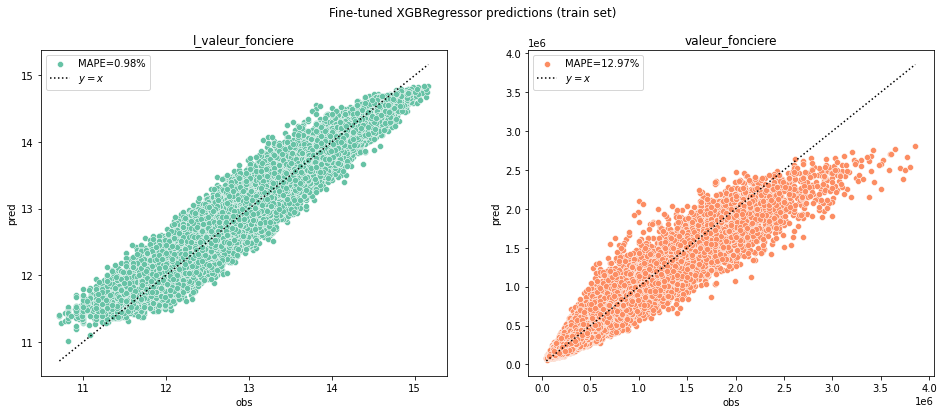

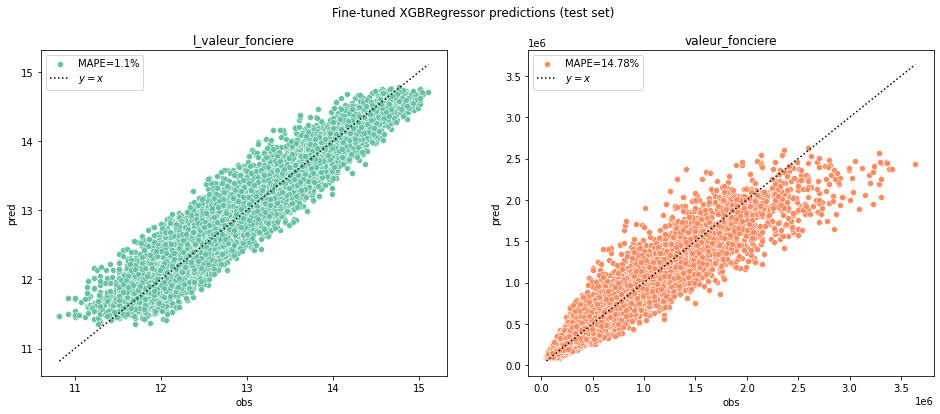

In [214]:
colors = sns.color_palette(palette="Set2", n_colors=2)

for dataset, preds in xgb_preds.items():

    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    fig.suptitle(f"Fine-tuned XGBRegressor predictions ({dataset} set)", fontsize=12)

    for target, ax, color in zip(["l_valeur_fonciere", "valeur_fonciere"], axes.flatten(), colors):

        plot_predictions(
            y_true=preds[target]["y_true"],
            y_pred=preds[target]["y_pred"],
            color=color,
            title=target,
            ax=ax);